# 3.1.2 Performance evaluation of ML model on training dataset

In [14]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

from xgboost import XGBRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from scripts.helpers import get_ytrue_y_pred_agg
from scripts.helpers import get_ytrue_y_pred_agg_season
from scripts.helpers import get_prediction_per_season_test

from scripts.model_classes import CustomXGBRegressor

#from plotting_functions import plot_prediction_per_fold
from scripts.plotting_functions import plot_prediction
from scripts.plotting_functions import plot_gsearch_results
from scripts.plotting_functions import plot_prediction_per_season


## Helper functions

In [15]:
# Get modelled mass balance 
def get_modelled_mb(df, ds, type):

    mb_modelled = []

    # Loop through each row of df to extract modelled mb for the given ID, year, and nearest elevation
    for row in df.itertuples(index=False):

        current_year = str(row.year) + '-10-01'
        current_altitude = row.altitude
        current_id = str(row.ID)
        current_year_dt = np.datetime64(current_year)

        if current_year_dt in ds['time'].values:

            # Find nearest elevation to point
            nearest_elevation_idx = abs(ds['elevation'] - current_altitude).argmin()
            nearest_elevation = ds['elevation'][nearest_elevation_idx]

            if current_id in ds['ID'].values:

                mb_val = ds[type].sel(
                    ID=current_id, time=current_year_dt, elevation=nearest_elevation).values

                mb_val = mb_val.item()
            else:
                mb_val = np.nan
        else:

            mb_val = np.nan

        mb_modelled.append(mb_val)

    return mb_modelled


## Plotting functions

In [16]:
# Plot modelled and observed point mass balances
def plot_point_modelled(df, model, start_yr, end_yr):

    """
    df : pd.Dataframe of point mb
    type : str, variable in ds; 'netto', 'summer' or 'winter'
    model : str, model name; 'glogem', 'oggm', 'pygem'
    """

    df_clean_dropna = df.dropna(subset=['mb_'+model])

    df_clean = df_clean_dropna[(df_clean_dropna['year'] >= start_yr) & (df_clean_dropna['year'] <= end_yr)]

    y_data = df_clean['mb_'+model]
    x_data = df_clean['balance']
    
    xy = np.vstack([x_data, y_data])
    z = gaussian_kde(xy)(xy)

    df_with_density = pd.DataFrame({
        'x': x_data,
        'y': y_data,
        'z': z
        })

    df_with_density.sort_values('z', inplace=True)

    fig, ax = plt.subplots()
    scatter = ax.scatter(df_with_density['x'], df_with_density['y'], c=df_with_density['z'], s=50, cmap='viridis')

    max_val = max(x_data.max(), y_data.max())+0.5
    min_val = min(x_data.min(), y_data.min())-0.5
    
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, label='1:1 Line')
    ax.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel('mb stake (m w.e.)')
    ax.set_ylabel('mb modelled elev band (m w.e.)')
    plt.title('Stake vs. ' + model)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_data, x_data))
    mae = mean_absolute_error(y_data, x_data) 
    r2 = r2_score(y_data, x_data) 
    count = len(x_data)
    
    stats_text = f'Count: {count}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}'
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.5))
    
    #plt.legend()
    plt.colorbar(ax.collections[0], ax=ax, label='Density')
    plt.tight_layout()
    plt.grid(alpha=0.5)
    plt.show()


## Get training dataset 

In [17]:
# Specify filepaths and filenames.          
loc = 'local'

if loc == 'cryocloud':
    filepath = '/home/jovyan/ML_MB_Norway_data/'
elif loc == 'local':
    filepath = 'Data/'

filename = '2023-08-28_stake_mb_norway_cleaned_ids_latlon_wattributes_climate_svf_monthly.csv'

# Load data.
df_train_final = pd.read_csv(filepath + filename, index_col=0)

In [18]:
df_train_final

,id,BREID,RGIID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67904,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
67905,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
67906,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
67907,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


In [19]:
df_train_final['ID'] = df_train_final['RGIID'].str[-4:] 

df_train_final.ID = df_train_final.ID.astype(int)
df_train_final

,id,BREID,RGIID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702,2436
1,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953,2436
2,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025,2436
3,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591,2436
4,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047,2436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67904,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908,2643
67905,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480,2643
67906,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605,2643
67907,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391,2643


### Get targets and features for ML model

In [22]:
# Select features for train
df_train_X_reduce = df_train_final.drop(['balance','year','BREID','RGIID', 'ID',], axis=1)

# Move id and n_months to the end of the dataframe (these are to be used as metadata)
df_train_X = df_train_X_reduce[[c for c in df_train_X_reduce if c not in ['id','n_months','month']] + ['id','n_months','month']]

# Select labels for train
df_train_y = df_train_final[['balance']]

# Get arrays of features+metadata and targets
X_train, y_train = df_train_X.values, df_train_y.values

In [23]:
df_train_X_reduce

,id,altitude_diff,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp
0,0,11.181943,2.509464,0.238202,0.883281,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702
1,0,11.181943,2.509464,0.238202,0.883281,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953
2,0,11.181943,2.509464,0.238202,0.883281,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025
3,0,11.181943,2.509464,0.238202,0.883281,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591
4,0,11.181943,2.509464,0.238202,0.883281,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67904,8497,-592.166788,2.526225,0.068208,0.971815,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908
67905,8497,-592.166788,2.526225,0.068208,0.971815,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480
67906,8497,-592.166788,2.526225,0.068208,0.971815,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605
67907,8497,-592.166788,2.526225,0.068208,0.971815,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391


### Get dataframes of annual, summer and winter mass balances for comparison

In [24]:
df_train_final

,id,BREID,RGIID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,month,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,may,274.658875,1.493194e+04,-375995.0,18766128.0,0.596335,-2832247.00,0.001702,2436
1,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jun,274.336243,-1.636112e+05,-521774.5,21166500.0,0.613368,-2748427.50,0.001953,2436
2,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,jul,277.882172,-1.717710e+06,-2857569.5,15175713.0,0.282537,-3019285.50,0.004025,2436
3,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,aug,281.432678,-1.826724e+06,-3644167.5,11799862.0,0.123184,-4122848.50,0.002591,2436
4,0,596,RGI60-08.02436,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5,sep,276.588593,-4.764911e+05,-1239184.5,6023235.0,0.295263,-2144487.50,0.006047,2436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67904,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,may,274.327118,-9.279995e+05,-247320.5,17505508.0,0.618479,-2179443.00,0.004908,2643
67905,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jun,277.050171,-8.421614e+05,101172.0,20268490.0,0.551025,-2504472.50,0.007480,2643
67906,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,jul,278.294403,-4.923712e+05,282694.5,15490057.0,0.481296,-862670.75,0.006605,2643
67907,8497,3129,RGI60-08.02643,1967,-592.166788,1.58,2.526225,0.068208,0.971815,12,aug,280.939240,-1.117702e+06,-2140415.0,12475600.0,0.284415,-2001555.00,0.006391,2643


In [25]:
df_train_annual = df_train_final[df_train_final['n_months']==12]
df_train_annual = df_train_annual.groupby(by=['id']).mean() 
df_train_annual

C:\Users\kasj\AppData\Local\Temp\ipykernel_16876\297526477.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_annual = df_train_annual.groupby(by=['id']).mean()


,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,
5653,596.0,1963.0,11.181943,-1.76,2.509464,0.238202,0.883281,12.0,268.210615,-161858.763021,-7.004038e+05,8.086886e+06,0.640043,-2.010340e+06,0.004099,2436.0
5654,596.0,1964.0,5.181943,-0.30,2.474161,0.117946,0.957209,12.0,268.655726,-57601.270833,-3.895262e+05,8.041898e+06,0.692069,-1.742578e+06,0.004279,2436.0
5655,596.0,1966.0,13.181943,-2.18,2.509464,0.238202,0.883281,12.0,265.865763,-268262.234375,-8.176957e+05,7.858361e+06,0.627273,-2.034467e+06,0.002969,2436.0
5656,596.0,1967.0,11.181943,-1.68,2.478294,0.146882,0.960949,12.0,268.612330,5310.908854,-4.825214e+05,7.691860e+06,0.664983,-1.817079e+06,0.003304,2436.0
5657,596.0,1968.0,11.181943,-0.31,2.478294,0.146882,0.960949,12.0,267.286813,-23087.184896,-3.665487e+05,7.291900e+06,0.672932,-1.671798e+06,0.003376,2436.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,3129.0,1968.0,-556.166788,0.90,2.115165,0.111223,0.953703,12.0,273.152740,-703103.671875,-9.029254e+05,9.853025e+06,0.540420,-2.517238e+06,0.006719,2643.0
8494,3129.0,1964.0,-576.166788,0.91,2.312361,0.097301,0.969350,12.0,271.989232,-538294.567708,-9.044572e+05,8.440202e+06,0.536171,-2.104698e+06,0.006724,2643.0
8495,3129.0,1965.0,-592.166788,0.19,2.482095,0.070551,0.966856,12.0,272.027824,-617945.161458,-9.860913e+05,9.806753e+06,0.538960,-2.577525e+06,0.005387,2643.0


In [26]:
df_train_winter = df_train_final[df_train_final['n_months']==7]
df_train_winter = df_train_winter.groupby(by=['id']).mean() 
df_train_winter

C:\Users\kasj\AppData\Local\Temp\ipykernel_16876\836084938.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_winter = df_train_winter.groupby(by=['id']).mean()


,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,
2901,596.0,1963.0,11.181943,1.65,2.509464,0.238202,0.883281,7.0,261.946974,318185.647321,33406.428571,3.444456e+06,0.824261,-1.322397e+06,0.004695,2436.0
2902,596.0,1964.0,5.181943,1.86,2.474161,0.117946,0.957209,7.0,264.280465,217448.517857,-21630.214286,3.666902e+06,0.813325,-1.395027e+06,0.004708,2436.0
2903,596.0,1966.0,13.181943,0.72,2.509464,0.238202,0.883281,7.0,259.181758,338602.866071,-3284.642857,3.668350e+06,0.778347,-1.498481e+06,0.002598,2436.0
2904,596.0,1967.0,11.181943,1.48,2.478294,0.146882,0.960949,7.0,263.024196,357241.968750,31364.000000,3.426551e+06,0.826897,-1.383288e+06,0.003033,2436.0
2905,596.0,1968.0,11.181943,1.59,2.478294,0.146882,0.960949,7.0,262.127980,320638.174107,11048.928571,3.179596e+06,0.820864,-1.205008e+06,0.003560,2436.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5648,3129.0,1968.0,-556.166788,3.25,2.115165,0.111223,0.953703,7.0,268.456704,-65694.544643,-143885.285714,4.919700e+06,0.691682,-1.678696e+06,0.008707,2643.0
5649,3129.0,1964.0,-576.166788,2.20,2.312361,0.097301,0.969350,7.0,267.719901,32.901786,-113394.500000,5.012583e+06,0.675496,-1.842936e+06,0.005465,2643.0
5650,3129.0,1965.0,-592.166788,1.99,2.482095,0.070551,0.966856,7.0,267.291643,-84333.687500,-190606.357143,5.498730e+06,0.692987,-1.972979e+06,0.005854,2643.0


In [27]:
df_train_summer = df_train_final[df_train_final['n_months']==5]
df_train_summer = df_train_summer.groupby(by=['id']).mean() 
df_train_summer

C:\Users\kasj\AppData\Local\Temp\ipykernel_16876\3686581347.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_train_summer = df_train_summer.groupby(by=['id']).mean()


,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
id,,,,,,,,,,,,,,,,
0,596.0,1963.0,11.181943,-3.41,2.509464,0.238202,0.883281,5.0,276.979712,-8.339209e+05,-1727738.20,14586287.6,0.382137,-2973459.20,0.003264,2436.0
1,596.0,1964.0,5.181943,-2.16,2.474161,0.117946,0.957209,5.0,274.781091,-4.426710e+05,-904580.55,14166891.9,0.522311,-2229149.00,0.003677,2436.0
2,596.0,1966.0,13.181943,-2.90,2.509464,0.238202,0.883281,5.0,275.223370,-1.117873e+06,-1957871.15,13724377.2,0.415769,-2784846.95,0.003487,2436.0
3,596.0,1967.0,11.181943,-3.16,2.478294,0.146882,0.960949,5.0,276.435718,-4.873926e+05,-1201961.00,13663292.7,0.438304,-2424386.35,0.003684,2436.0
4,596.0,1968.0,11.181943,-1.90,2.478294,0.146882,0.960949,5.0,274.509180,-5.043027e+05,-895185.35,13049126.0,0.465827,-2325303.60,0.003118,2436.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,3129.0,1968.0,-556.166788,-2.35,2.115165,0.111223,0.953703,5.0,279.727191,-1.595476e+06,-1965581.45,16759681.6,0.328654,-3691196.20,0.003937,2643.0
2897,3129.0,1964.0,-576.166788,-1.29,2.312361,0.097301,0.969350,5.0,277.966296,-1.291953e+06,-2011945.00,13238867.6,0.341115,-2471164.25,0.008487,2643.0
2898,3129.0,1965.0,-592.166788,-1.80,2.482095,0.070551,0.966856,5.0,278.658478,-1.365001e+06,-2099770.30,15837985.2,0.323321,-3423888.65,0.004735,2643.0


In [28]:
df_train_annual.reset_index(drop=True, inplace=True)
df_train_winter.reset_index(drop=True, inplace=True)
df_train_summer.reset_index(drop=True, inplace=True)

df_train_annual.ID = df_train_annual.ID.astype(np.int64)
df_train_winter.ID = df_train_winter.ID.astype(np.int64)
df_train_summer.ID = df_train_summer.ID.astype(np.int64)
df_train_annual['ID'] = df_train_annual['ID'].astype(str).str.zfill(4).str[-4:]
df_train_winter['ID'] = df_train_winter['ID'].astype(str).str.zfill(4).str[-4:]
df_train_summer['ID'] = df_train_summer['ID'].astype(str).str.zfill(4).str[-4:]

df_train_annual.year = df_train_annual.year.astype(np.int64)
df_train_winter.year = df_train_winter.year.astype(np.int64)
df_train_summer.year = df_train_summer.year.astype(np.int64)

## Get ML-model predictions

In [29]:
# Model trained on cluster using folds split on cycle of years and skyview factor as feature - USING ALL ANNUAL, SUMMER, WINTER DATA
with open('Training_cluster/2024-10-24_10-30-28/custom_loss_cv_grid.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

best_model = clf_loaded.best_estimator_
best_model

CustomXGBRegressor(base_score=None, booster=None, callbacks=None,
                   colsample_bylevel=None, colsample_bynode=None,
                   colsample_bytree=None, device=None,
                   early_stopping_rounds=None, enable_categorical=False,
                   eval_metric=None, feature_types=None, gamma=0,
                   grow_policy=None, importance_type=None,
                   interaction_constraints=None, learning_rate=0.05,
                   max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                   max_delta_step=None, max_depth=5, max_leaves=None,
                   min_child_weight=0, missing=nan, monotone_constraints=None,
                   multi_strategy=None, n_estimators=300, n_jobs=None,
                   num_parallel_tree=None,
                   objective=<function CustomXGBRegressor.fit.<locals>.custom_objective at 0x0000026A0C5F5750>, ...)

C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kasj\AppData\Local\anaconda3\envs\ML_MB_Norway_envi\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


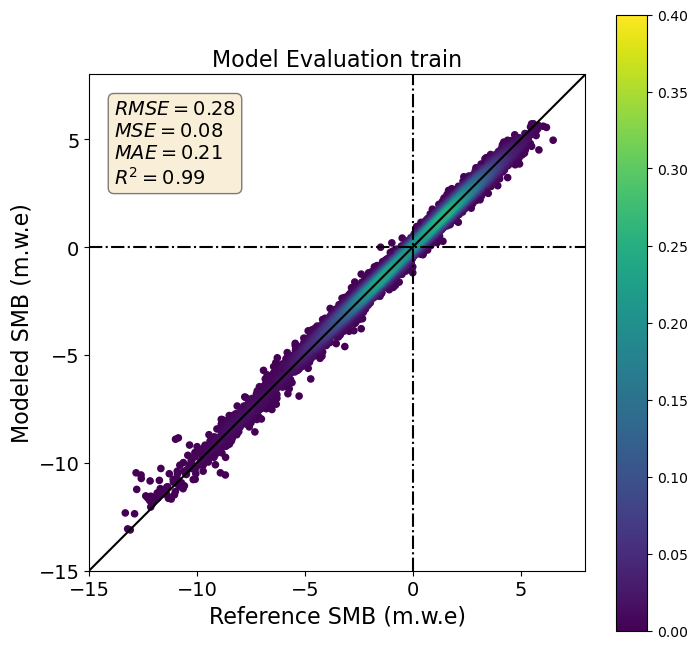

In [30]:
train_pred = best_model.predict(X_train)

# Get test true values and predictions
y_train_mean, y_train_pred_agg = get_ytrue_y_pred_agg(y_train,train_pred,X_train)

# Plot predictions vs true values for test
plot_prediction(y_train_mean, y_train_pred_agg, data_type='train')

In [31]:
y_train_winter, y_pred_winter = get_prediction_per_season_test(X_train, y_train, best_model, months=7)
winter_indices = X_train[:, -2] == 7
X_train_winter = X_train[winter_indices]
y_train_winter_mean, y_pred_winter_agg = get_ytrue_y_pred_agg_season(y_train_winter, y_pred_winter, X_train_winter, months=7)

df_train_winter['mb_ML'] = y_pred_winter_agg

In [32]:
df_train_winter

,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_ML
0,596.0,1963,11.181943,1.65,2.509464,0.238202,0.883281,7.0,261.946974,318185.647321,33406.428571,3.444456e+06,0.824261,-1.322397e+06,0.004695,2436,1.722133
1,596.0,1964,5.181943,1.86,2.474161,0.117946,0.957209,7.0,264.280465,217448.517857,-21630.214286,3.666902e+06,0.813325,-1.395027e+06,0.004708,2436,1.479645
2,596.0,1966,13.181943,0.72,2.509464,0.238202,0.883281,7.0,259.181758,338602.866071,-3284.642857,3.668350e+06,0.778347,-1.498481e+06,0.002598,2436,0.548435
3,596.0,1967,11.181943,1.48,2.478294,0.146882,0.960949,7.0,263.024196,357241.968750,31364.000000,3.426551e+06,0.826897,-1.383288e+06,0.003033,2436,1.096780
4,596.0,1968,11.181943,1.59,2.478294,0.146882,0.960949,7.0,262.127980,320638.174107,11048.928571,3.179596e+06,0.820864,-1.205008e+06,0.003560,2436,1.275286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2747,3129.0,1968,-556.166788,3.25,2.115165,0.111223,0.953703,7.0,268.456704,-65694.544643,-143885.285714,4.919700e+06,0.691682,-1.678696e+06,0.008707,2643,3.172133
2748,3129.0,1964,-576.166788,2.20,2.312361,0.097301,0.969350,7.0,267.719901,32.901786,-113394.500000,5.012583e+06,0.675496,-1.842936e+06,0.005465,2643,2.176753
2749,3129.0,1965,-592.166788,1.99,2.482095,0.070551,0.966856,7.0,267.291643,-84333.687500,-190606.357143,5.498730e+06,0.692987,-1.972979e+06,0.005854,2643,2.187411
2750,3129.0,1966,-595.166788,1.70,2.339748,0.073072,0.968909,7.0,264.344670,-9777.187500,-182108.214286,5.375194e+06,0.646054,-2.015307e+06,0.004513,2643,1.623715


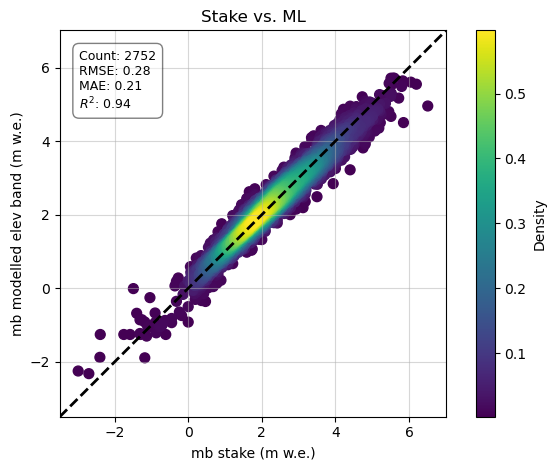

In [33]:
plot_point_modelled(df_train_winter, 'ML', 1959, 2022)

In [34]:
df_train_summer

,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID
0,596.0,1963,11.181943,-3.41,2.509464,0.238202,0.883281,5.0,276.979712,-8.339209e+05,-1727738.20,14586287.6,0.382137,-2973459.20,0.003264,2436
1,596.0,1964,5.181943,-2.16,2.474161,0.117946,0.957209,5.0,274.781091,-4.426710e+05,-904580.55,14166891.9,0.522311,-2229149.00,0.003677,2436
2,596.0,1966,13.181943,-2.90,2.509464,0.238202,0.883281,5.0,275.223370,-1.117873e+06,-1957871.15,13724377.2,0.415769,-2784846.95,0.003487,2436
3,596.0,1967,11.181943,-3.16,2.478294,0.146882,0.960949,5.0,276.435718,-4.873926e+05,-1201961.00,13663292.7,0.438304,-2424386.35,0.003684,2436
4,596.0,1968,11.181943,-1.90,2.478294,0.146882,0.960949,5.0,274.509180,-5.043027e+05,-895185.35,13049126.0,0.465827,-2325303.60,0.003118,2436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,3129.0,1968,-556.166788,-2.35,2.115165,0.111223,0.953703,5.0,279.727191,-1.595476e+06,-1965581.45,16759681.6,0.328654,-3691196.20,0.003937,2643
2897,3129.0,1964,-576.166788,-1.29,2.312361,0.097301,0.969350,5.0,277.966296,-1.291953e+06,-2011945.00,13238867.6,0.341115,-2471164.25,0.008487,2643
2898,3129.0,1965,-592.166788,-1.80,2.482095,0.070551,0.966856,5.0,278.658478,-1.365001e+06,-2099770.30,15837985.2,0.323321,-3423888.65,0.004735,2643
2899,3129.0,1966,-595.166788,-2.81,2.339748,0.073072,0.968909,5.0,279.158905,-1.707581e+06,-2904290.60,14429075.0,0.268207,-3324879.05,0.005865,2643


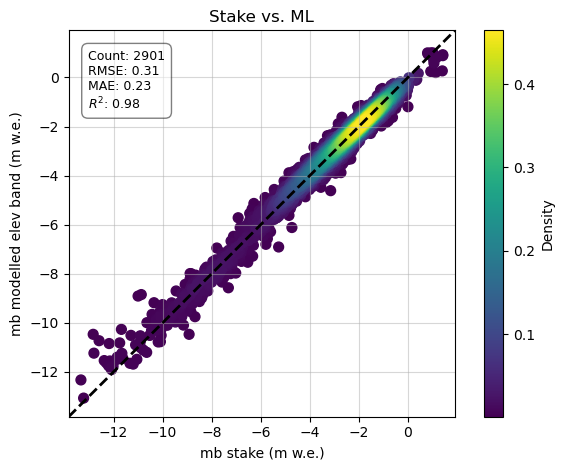

In [35]:
y_train_summer, y_pred_summer = get_prediction_per_season_test(X_train, y_train, best_model, months=5)
summer_indices = X_train[:, -2] == 5
X_train_summer = X_train[summer_indices]
y_train_summer_mean, y_pred_summer_agg = get_ytrue_y_pred_agg_season(y_train_summer, y_pred_summer, X_train_summer, months=5)

df_train_summer['mb_ML'] = y_pred_summer_agg
plot_point_modelled(df_train_summer, 'ML', 1959, 2022)

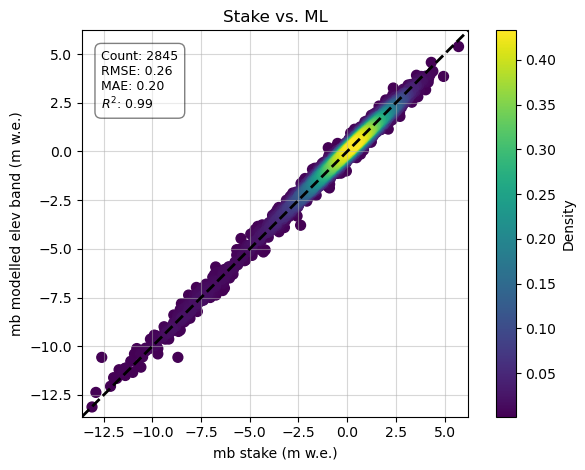

In [36]:
y_train_annual, y_pred_annual = get_prediction_per_season_test(X_train, y_train, best_model, months=12)
annual_indices = X_train[:, -2] == 12
X_train_annual = X_train[annual_indices]
y_train_annual_mean, y_pred_annual_agg = get_ytrue_y_pred_agg_season(y_train_annual, y_pred_annual, X_train_annual, months=12)

df_train_annual['mb_ML'] = y_pred_annual_agg
plot_point_modelled(df_train_annual, 'ML', 1959, 2022)

## Plot modelled point mass balance against observed point mass balance for all models

In [37]:
# PLOT POINTS WITH GAUSSIAN KDE (WORKS ONLY FOR COMMON TIME PERIOD DUE TO SORTING)
# Three dataframes that only contain predictions for test glaciers:
# df_test_annual
# df_test_winter
# df_test_summer

# Each df contains the following columns: 
# year, balance, mb_glogem, mb_oggm, mb_pygem, mb_ML

# Set the start and end years for the filter
start_year = 1960#1979
end_year = 2021#2019

gl = 'all'

# Function to filter DataFrame based on year range
def filter_df_by_year(df, start_year, end_year):
    return df[(df['year'] >= start_year) & (df['year'] <= end_year)]

# Filter the DataFrames
#df_obs_nonan = df_obs.dropna(subset=['RGIID'])
if gl == 'test':
    print('test')
    #df_obs_nonan = filter_df_by_rgiid_and_year(df_obs_nonan, test_glaciers, start_year, end_year)
    #df_pred_filtered = filter_df_by_rgiid_and_year(df_pred, test_glaciers, start_year, end_year)
    #df_oggm_filtered = filter_df_by_rgiid_and_year(df_oggm, test_glaciers, start_year, end_year)
    #df_glogem_filtered = filter_df_by_rgiid_and_year(df_glogem, test_glaciers, start_year, end_year)
    #df_pygem_filtered = filter_df_by_rgiid_and_year(df_pygem, test_glaciers, start_year, end_year)
elif gl == 'all':
    df_annual_filtered = filter_df_by_year(df_train_annual, start_year, end_year)
    df_winter_filtered = filter_df_by_year(df_train_winter, start_year, end_year)
    df_summer_filtered = filter_df_by_year(df_train_summer, start_year, end_year)

# List of model columns and corresponding labels
models = [('mb_ML', 'XGBoost')]
#models = [('mb_ML', 'Mass Balance Machine'), ('mb_oggm', 'OGGM'), ('mb_glogem', 'GloGEM'), ('mb_pygem', 'PyGEM')]

def remove_nan_rows(df, model_cols):
    """Remove rows with NaNs in the 'balance' column or any of the model columns."""
    columns_to_check = ['balance'] + model_cols
    return df.dropna(subset=columns_to_check)



In [38]:
# List of model columns
model_cols = ['mb_ML']
#model_cols = ['mb_ML', 'mb_oggm', 'mb_glogem', 'mb_pygem']

# Filter DataFrames to remove rows with NaNs in relevant columns
df_annual_filtered = remove_nan_rows(df_annual_filtered, model_cols)
df_winter_filtered = remove_nan_rows(df_winter_filtered, model_cols)
df_summer_filtered = remove_nan_rows(df_summer_filtered, model_cols)


In [39]:
df_annual_filtered['Type'] = 'Ba'
df_winter_filtered['Type'] = 'Bw'
df_summer_filtered['Type'] = 'Bs'

combined_df = pd.concat([df_annual_filtered, df_winter_filtered, df_summer_filtered], ignore_index=True)

def gaussian_kde_plot(x_,y_):
    xy = np.vstack([x_,y_])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x_[idx], y_[idx], z[idx]
    return x, y, z

from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm=1/2.54
fontsize = 8
fontsize_small = 8.0
fontsize_min = 8.0
markersize = 20
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

In [40]:
combined_df

,BREID,year,altitude_diff,balance,aspect,slope,skyview_factor,n_months,t2m,sshf,slhf,ssrd,fal,str,tp,ID,mb_ML,Type
0,596.0,1963,11.181943,-1.76,2.509464,0.238202,0.883281,12.0,268.210615,-1.618588e+05,-7.004038e+05,8.086886e+06,0.640043,-2.010340e+06,0.004099,2436,-1.289059,Ba
1,596.0,1964,5.181943,-0.30,2.474161,0.117946,0.957209,12.0,268.655726,-5.760127e+04,-3.895262e+05,8.041898e+06,0.692069,-1.742578e+06,0.004279,2436,-0.407317,Ba
2,596.0,1966,13.181943,-2.18,2.509464,0.238202,0.883281,12.0,265.865763,-2.682622e+05,-8.176957e+05,7.858361e+06,0.627273,-2.034467e+06,0.002969,2436,-2.334021,Ba
3,596.0,1967,11.181943,-1.68,2.478294,0.146882,0.960949,12.0,268.612330,5.310909e+03,-4.825214e+05,7.691860e+06,0.664983,-1.817079e+06,0.003304,2436,-1.518283,Ba
4,596.0,1968,11.181943,-0.31,2.478294,0.146882,0.960949,12.0,267.286813,-2.308718e+04,-3.665487e+05,7.291900e+06,0.672932,-1.671798e+06,0.003376,2436,-0.396535,Ba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,3129.0,1968,-556.166788,-2.35,2.115165,0.111223,0.953703,5.0,279.727191,-1.595476e+06,-1.965581e+06,1.675968e+07,0.328654,-3.691196e+06,0.003937,2643,-2.395889,Bs
8494,3129.0,1964,-576.166788,-1.29,2.312361,0.097301,0.969350,5.0,277.966296,-1.291953e+06,-2.011945e+06,1.323887e+07,0.341115,-2.471164e+06,0.008487,2643,-1.288136,Bs
8495,3129.0,1965,-592.166788,-1.80,2.482095,0.070551,0.966856,5.0,278.658478,-1.365001e+06,-2.099770e+06,1.583799e+07,0.323321,-3.423889e+06,0.004735,2643,-1.779159,Bs
8496,3129.0,1966,-595.166788,-2.81,2.339748,0.073072,0.968909,5.0,279.158905,-1.707581e+06,-2.904291e+06,1.442908e+07,0.268207,-3.324879e+06,0.005865,2643,-2.439768,Bs


## Point metrics

In [41]:
# Calculate RMSE, MSE, and bias

metrics = {}
labels = ['Mass Balance Machine', 'OGGM', 'GloGEM', 'PyGEM']

print('Metrics based on period :')
print(str(start_year))
print(str(end_year))

for idx, model in enumerate(model_cols):
    label = labels[idx]

    metrics[label] = {}

    for metric in ['Ba', 'Bw', 'Bs']:
        modeled = combined_df[combined_df['Type']==metric][model].values
        observed = combined_df[combined_df['Type']==metric]['balance'].values 
        rmse = root_mean_squared_error(observed, modeled)
        mse = mean_squared_error(observed, modeled)
        mae = np.mean(abs(modeled - observed))
        bias = np.mean(modeled - observed)
        r2 = r2_score(observed, modeled) 
        count = len(observed)  # Count valid pairs
        
        metrics[label][metric] = {'rmse': rmse, 'mse': mse, 'mae': mae, 'bias': bias, 'r2':r2, 'count': count}

        print(f'{label} - {metric}: RMSE={rmse:.2f}, MSE={mse:.2f}, MAE={mae:.2f}, Bias={bias:.2f}, R²={r2:.2f}, Count={count}')

Metrics based on period :
1960
2021
Mass Balance Machine - Ba: RMSE=0.26, MSE=0.07, MAE=0.20, Bias=-0.00, R²=0.99, Count=2845
Mass Balance Machine - Bw: RMSE=0.28, MSE=0.08, MAE=0.21, Bias=0.00, R²=0.95, Count=2752
Mass Balance Machine - Bs: RMSE=0.31, MSE=0.10, MAE=0.23, Bias=0.00, R²=0.98, Count=2901


## Figure Appendix: Point performance XGBoost Model per glacier on train

C:\Users\kasj\AppData\Local\Temp\ipykernel_2192\3689119862.py:84: MatplotlibDeprecationWarning: The remove function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().remove(ax)  #disable shared x-axis
C:\Users\kasj\AppData\Local\Temp\ipykernel_2192\3689119862.py:87: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.get_shared_x_axes().join(ax, axs[0])


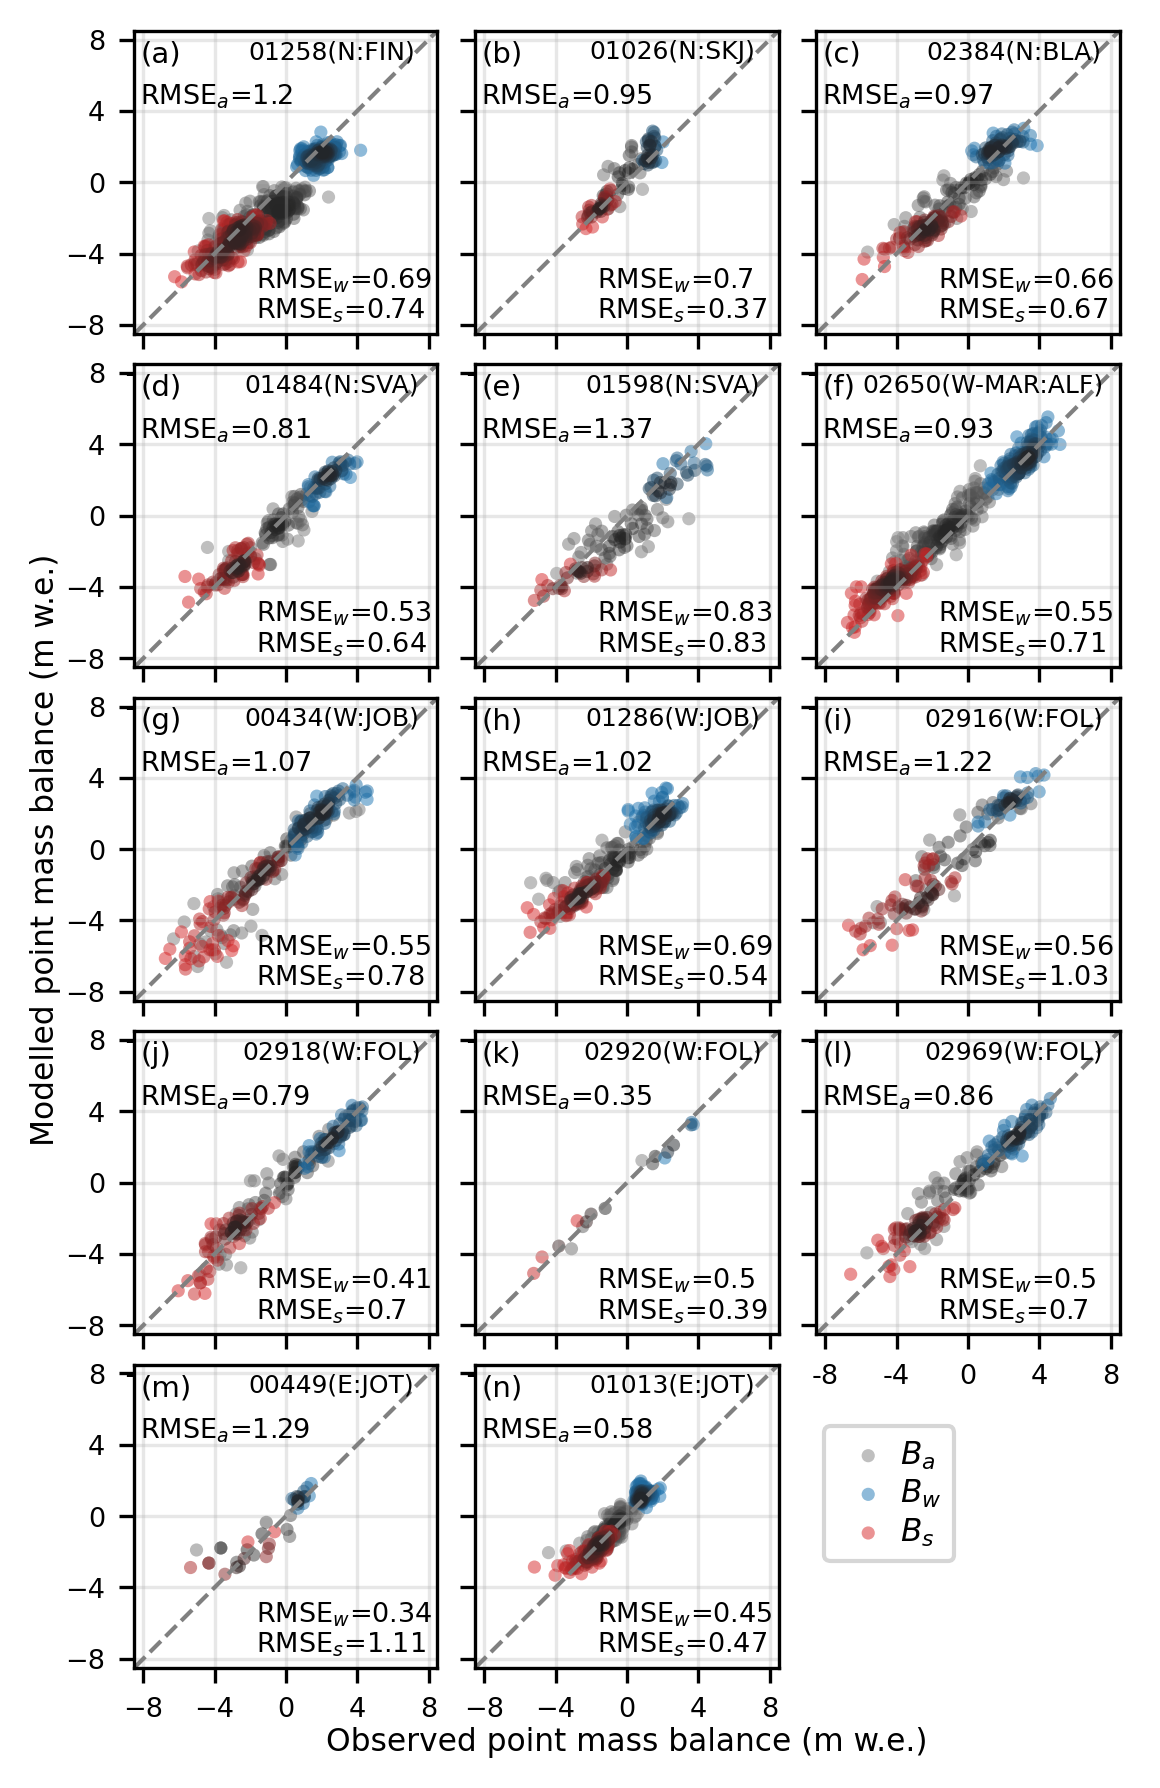

In [33]:
from matplotlib.colors import ListedColormap
my_cmap_blue = sns.dark_palette('tab:blue', n_colors=8, as_cmap=True, reverse=True)
my_cmap_red = sns.dark_palette('tab:red', n_colors=8, as_cmap=True, reverse=True)
my_cmap_black = sns.dark_palette('grey', n_colors=8, as_cmap=True, reverse=True)
my_alpha = 0.5

cm = 1/2.54
fontsize = 7
fontsize_small = 6.5
markersize = 10
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

# Ordered north to south
test_glaciers = ['1258','1026', '2384','1484','1598','2650','0434','1286','2916','2918','2920','2969','0449','1013']
glaciers_loc = ['(N:FIN)','(N:SKJ)','(N:BLA)','(N:SVA)','(N:SVA)','(W-MAR:ALF)','(W:JOB)','(W:JOB)', '(W:FOL)','(W:FOL)','(W:FOL)',
                '(W:FOL)','(E:JOT)','(E:JOT)']
                 
combined_df_ordered = combined_df[combined_df['ID'].isin(test_glaciers)]
combined_df_ordered['ID'] = pd.Categorical(combined_df_ordered['ID'], categories=test_glaciers, ordered=True)
combined_df_ordered = combined_df_ordered.sort_values('ID')

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

fig, axs = plt.subplots(5, 3, figsize=(11 * cm, 18 * cm), sharey=True, dpi=300)
axs = axs.flatten()

tick_min = -8
tick_max = 8
ticks = np.arange(tick_min, tick_max + 1, 4)
model_cols = ['mb_ML']
labels = ['Mass Balance Machine']
glaciers = list(combined_df_ordered.ID.unique())
breid = list(combined_df_ordered.BREID.unique())
n = 14 # number of glaciers

plot_index = 0
for i, glacier in enumerate(glaciers[:n]):
    df_glacier = combined_df_ordered[combined_df_ordered['ID'] == glacier]
    ax = axs[plot_index]

    for idx, model in enumerate(model_cols):
        label = labels[idx]

        for metric in ['Ba', 'Bw', 'Bs']:
            y_ = df_glacier[df_glacier['Type'] == metric][model].values
            x_ = df_glacier[df_glacier['Type'] == metric]['balance'].values
            x, y, z = gaussian_kde_plot(x_, y_)

            if metric == 'Ba':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_black, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{a}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.02, 0.83), xycoords='axes fraction', fontsize=6.5, va='top')
            elif metric == 'Bw':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_blue, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{w}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.4, 0.13), xycoords='axes fraction', fontsize=6.5, va='bottom', ha='left')
            elif metric == 'Bs':
                ax.scatter(x, y, c=z, s=markersize, edgecolors='none', cmap=my_cmap_red, alpha=my_alpha, label=metric)
                rmse = root_mean_squared_error(x_, y_)
                rmse_txt = "RMSE$_{s}$=" + str(round(rmse, 2))
                ax.annotate(rmse_txt, xy=(0.4, 0.03), xycoords='axes fraction', fontsize=6.5, va='bottom', ha='left')

    ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='--', color='gray', linewidth=1)
    ax.set_aspect('equal', 'box')
    ax.set_xlim(-8.5, 8.5)
    ax.set_ylim(-8.5, 8.5)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', which='major', labelsize=fontsize_small)
    ax.annotate(f'({chr(97 + plot_index)})', xy=(0.02, 0.97), xycoords='axes fraction', fontsize=7, ha='left', va='top')
    ax.legend().remove()

    if plot_index == 5:
        ax.annotate(f'0{glacier}'+glaciers_loc[i], xy=(0.55, 0.97), xycoords='axes fraction', fontsize=6, ha='center', va='top')
    else:
        ax.annotate(f'0{glacier}'+glaciers_loc[i], xy=(0.65, 0.97), xycoords='axes fraction', fontsize=6, ha='center', va='top')

    if plot_index == 11:
        orig_share_x = ax.get_shared_x_axes()
        ax.get_shared_x_axes().remove(ax)  #disable shared x-axis
        ax.set_xticks(ticks)
        ax.set_xticklabels([-8, -4, 0, 4, 8])
        ax.get_shared_x_axes().join(ax, axs[0])

    plot_index += 1

for ax in axs[plot_index:]:
    ax.axis('off')

axs[plot_index - 1].legend(['$B_{a}$','$B_{w}$','$B_{s}$'], frameon=True, loc='lower left', fontsize=7.5, ncol=1, 
               handlelength=2, handletextpad=0.02, borderaxespad=0.5, borderpad=0.4, labelspacing=0.2, 
               columnspacing=0.8, bbox_to_anchor=(1.1, 0.3))

axs[6].set_ylabel('Modelled point mass balance (m w.e.)', fontsize=7.5, labelpad=1)
axs[13].set_xlabel('Observed point mass balance (m w.e.)', fontsize=7.5, labelpad=1)

plt.subplots_adjust(wspace=0.05, hspace=0.1)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'point_mb_per_test_glacier_v2_B.pdf', format='pdf', bbox_inches='tight')

plt.show()

## Figure Appendix: Point performance and temporal bias MBM on train

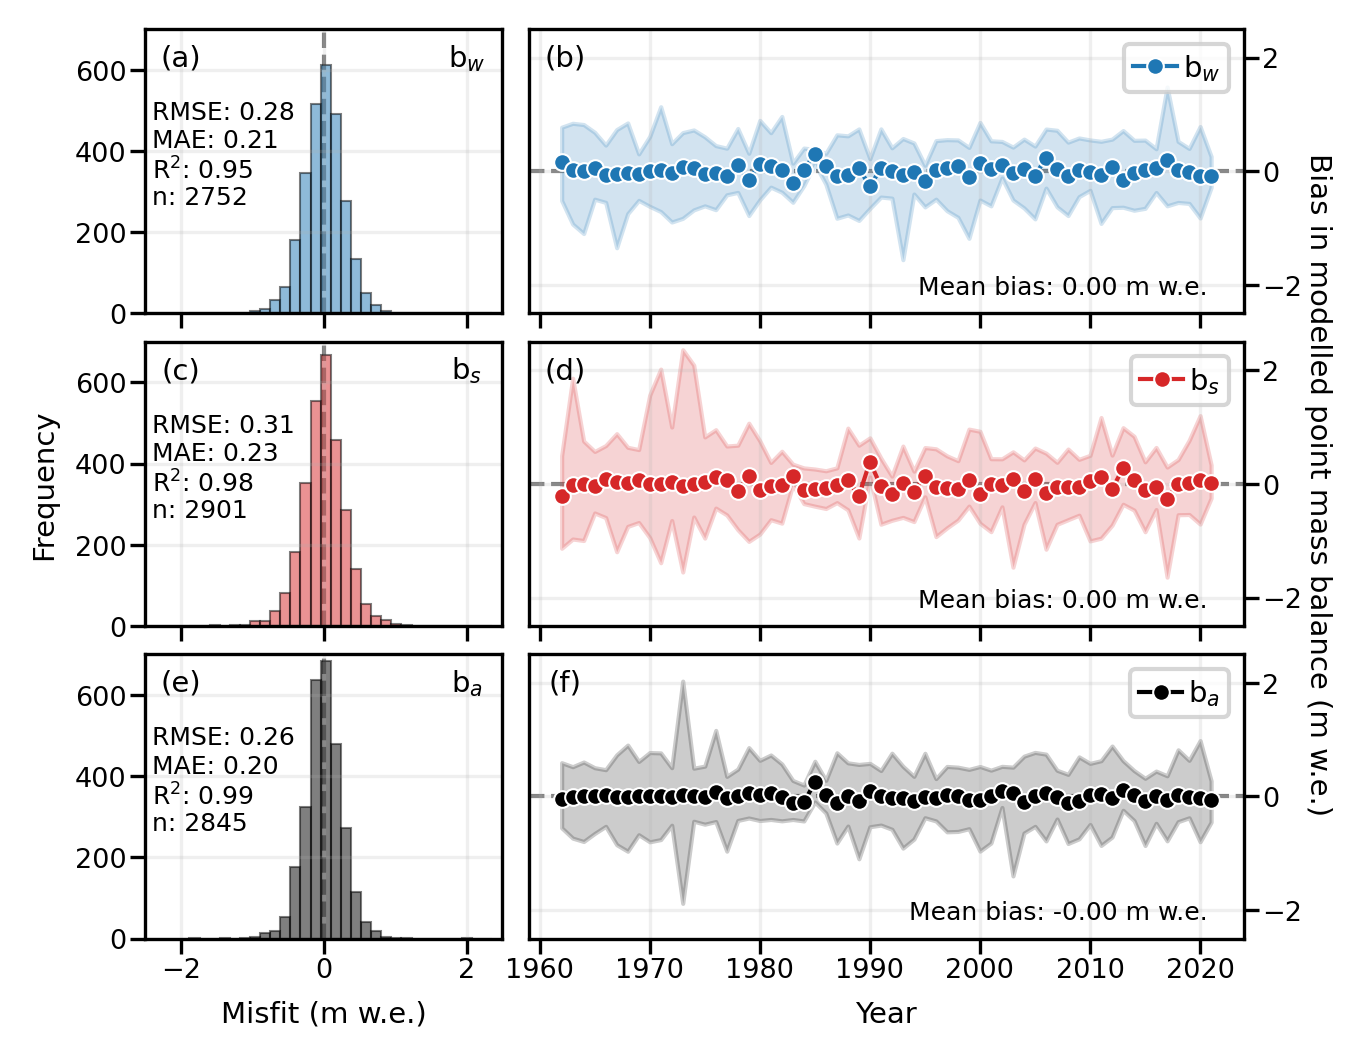

In [51]:
df = combined_df.copy()

df['residual'] = df['mb_ML'] - df['balance']

type_colors = {'Ba': 'black', 'Bs': 'C3', 'Bw': 'C0'}
cm = 1/2.54
fontsize = 7.0

fig = plt.figure(figsize=(12*cm, 10*cm), dpi=300)
gs = fig.add_gridspec(3, 2, width_ratios=[1, 2], hspace=0.1)

types_order = ['Bw', 'Bs', 'Ba']
annotations1 = ['(a)', '(c)', '(e)']
annotations2 = ['(b)', '(d)', '(f)']
types_labels = ['b$_w$', 'b$_s$', 'b$_a$']

for idx, t_type in enumerate(types_order):
    df_type = df[df['Type'] == t_type]
    
    # Histogram plot for residuals
    ax_hist = fig.add_subplot(gs[idx, 0])
    bins = np.histogram_bin_edges(df['residual'], bins=30) 
    ax_hist.hist(df_type['residual'], bins=bins, color=type_colors[t_type], alpha=0.5, edgecolor='black', linewidth=0.5)
    
    ax_hist.grid(alpha=0.2)
    ax_hist.yaxis.set_ticks_position('left')
    ax_hist.yaxis.set_label_position('left')
    ax_hist.set_xlabel('Misfit (m w.e.)', fontsize=fontsize)
    ax_hist.tick_params(axis='both', which='major', labelsize=fontsize)

    # Set y-axis limits and ticks on first column
    ax_hist.set_xlim(-2.5, 2.5)
    ax_hist.set_ylim(0, 700)
    ax_hist.set_yticks([0, 200, 400, 600])

    ax_hist.annotate(annotations1[idx], xy=(0.1, 0.90), 
                     xycoords='axes fraction', fontsize=fontsize,
                     ha='center', va='center')

    # Time series for residuals
    ax_ts = fig.add_subplot(gs[idx, 1])
    sns.lineplot(x='year', y='residual', 
                 data=df_type, marker='o', 
                 label=types_labels[idx],#t_type[-2]+'$_{'+t_type[-1]+'}$', 
                 ax=ax_ts, errorbar=("pi", 100), 
                 linewidth=1, color=type_colors[t_type],
                markeredgewidth=0.5)#, markersize=5)
    
    for line_obj in ax_ts.get_lines():
        line_obj.set_markersize(4)
    
    ax_ts.axhline(0, color='gray', linestyle='--', lw=1, zorder=0)
    ax_ts.set_ylim(-2.5, 2.5)
    ax_ts.set_yticks([-2, 0, 2])
    ax_ts.tick_params(axis='both', which='major', labelsize=6.5, pad=1)
    ax_ts.set_ylabel('')

    ax_hist.axvline(0, color='gray', linestyle='--', lw=1, zorder=0)
    ax_hist.tick_params(axis='both', which='major', labelsize=6.5, pad=1)

    ax_ts.grid(alpha=0.2)
    ax_ts.legend(fontsize=fontsize, handletextpad=0.2, handlelength=1.5, borderpad=0.3)

    ax_ts.annotate(annotations2[idx], xy=(0.05, 0.90), 
                   xycoords='axes fraction', fontsize=fontsize,
                   ha='center', va='center')

    ax_hist.annotate(types_labels[idx], xy=(0.90, 0.90), 
                   xycoords='axes fraction', fontsize=fontsize,
                   ha='center', va='center')

    ax_ts.yaxis.set_ticks_position('right')
    ax_ts.yaxis.set_label_position('right')

    if idx ==0:
        ax_ts.set_xticklabels([])
        ax_hist.set_xticklabels([])

    
    if idx == 1:
        ax_ts.set_ylabel('Bias in modelled point mass balance (m w.e.)', fontsize=fontsize, rotation=270, labelpad=7)
        ax_hist.set_ylabel('Frequency', fontsize=fontsize)
        ax_ts.set_xticklabels([])
        ax_hist.set_xticklabels([])


    if idx == 2:
        ax_ts.set_xlabel('Year', fontsize=fontsize)

    bias_value = metrics['Mass Balance Machine'][t_type]['bias']
    rmse_value = metrics['Mass Balance Machine'][t_type]['rmse']
    mae_value = metrics['Mass Balance Machine'][t_type]['mae']
    r2_value = metrics['Mass Balance Machine'][t_type]['r2']
    count_value = metrics['Mass Balance Machine'][t_type]['count']


    ax_ts.annotate(f'Mean bias: {bias_value:.2f} m w.e.', xy=(0.95, 0.05), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='right', va='bottom', color='black')

    ax_hist.annotate(f'RMSE: {rmse_value:.2f}', xy=(0.02, 0.75), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')

    ax_hist.annotate(f'MAE: {mae_value:.2f}', xy=(0.02, 0.65), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')
    
    ax_hist.annotate(f'R$^2$: {r2_value:.2f}', xy=(0.02, 0.55), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')

    ax_hist.annotate(f'n: {count_value:.0f}', xy=(0.02, 0.45), 
                   xycoords='axes fraction', fontsize=6, 
                   ha='left', va='top', color='black')

plt.subplots_adjust(wspace=0.05, hspace=0.03)

#pdf_path = 'C:/Users/kasj/OneDrive - Høgskulen på Vestlandet/Projects/2022_ML_for_MB_Norway/Figures_paper/'
#plt.savefig(pdf_path+'performance_point_train.pdf', format='pdf', bbox_inches='tight')

plt.show()
